In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyaccel import lattice as pyacc_lat
from pyaccel import optics as pyacc_opt
from pyaccel.optics import calc_touschek_energy_acceptance
from mathphys.functions import save_pickle, load_pickle
from apsuite.dynap import DynapXY, DynapEX, PhaseSpace
import pyaccel
import pymodels

from idanalysis import orbcorr as orbcorr

from idanalysis import optics as optics
from idanalysis import IDKickMap
import utils

from run_rk_traj import PHASES, GAPS
from utils import get_idconfig

In [2]:
def create_model_ids():
    """."""
    print('--- model with kickmap ---')
    ids = utils.create_ids_model(phase, gap, rescale_kicks=1)
    # ids = utils.create_ids(phase, gap, rescale_kicks=1)
    model = pymodels.si.create_accelerator(ids=ids)
    model.cavity_on = False
    model.radiation_on = 0
    twiss, *_ = pyaccel.optics.calc_twiss(model, indices='closed')
    print('length : {:.4f} m'.format(model.length))
    print('tunex  : {:.6f}'.format(twiss.mux[-1]/2/np.pi))
    print('tuney  : {:.6f}'.format(twiss.muy[-1]/2/np.pi))
    straight_nr = int(ids[0].subsec[2:4])
    # get knobs and beta locations
    if straight_nr is not None:
        _, knobs, _ = optics.symm_get_knobs(model, straight_nr)
        locs_beta = optics.symm_get_locs_beta(knobs)
    else:
        knobs, locs_beta = None, None

    return model, knobs, locs_beta

In [3]:
def calc_dtune_betabeat(twiss0, twiss1):
    """."""
    dtunex = (twiss1.mux[-1] - twiss0.mux[-1]) / 2 / np.pi
    dtuney = (twiss1.muy[-1] - twiss0.muy[-1]) / 2 / np.pi
    bbeatx = 100 * (twiss1.betax - twiss0.betax) / twiss0.betax
    bbeaty = 100 * (twiss1.betay - twiss0.betay) / twiss0.betay
    bbeatx_rms = np.std(bbeatx)
    bbeaty_rms = np.std(bbeaty)
    bbeatx_absmax = np.max(np.abs(bbeatx))
    bbeaty_absmax = np.max(np.abs(bbeaty))
    return (
      dtunex, dtuney, bbeatx, bbeaty,
      bbeatx_rms, bbeaty_rms, bbeatx_absmax, bbeaty_absmax)

In [4]:
def analysis_uncorrected_perturbation(
        model, idconfig, twiss0=None, plot_flag=True):
    """."""
    config_label = idconfig
    twiss, *_ = pyacc_opt.calc_twiss(model, indices='closed')

    results = calc_dtune_betabeat(twiss0, twiss)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]

    if plot_flag:

        print(f'dtunex: {dtunex:+.6f}')
        print(f'dtunex: {dtuney:+.6f}')
        txt = f'bbetax: {bbeatx_rms:04.1f} % rms, '
        txt += f'{bbeatx_absmax:04.1f} % absmax'
        print(txt)
        txt = f'bbetay: {bbeaty_rms:04.1f} % rms, '
        txt += f'{bbeaty_absmax:04.1f} % absmax'
        print(txt)

        labelx = f'X ({bbeatx_rms:.1f} % rms)'
        labely = f'Y ({bbeaty_rms:.1f} % rms)'
        plt.plot(twiss.spos, bbeatx, color='b', alpha=1, label=labelx)
        plt.plot(twiss.spos, bbeaty, color='r', alpha=0.8, label=labely)
        plt.xlabel('spos [m]')
        plt.ylabel('Beta Beat [%]')
        plt.title('Beta Beating from ID - ' + config_label)
        plt.legend()
        plt.grid()
        plt.show()

    return twiss

In [5]:
def plot_beta_beating(twiss0, twiss1, twiss2, twiss3, config_label):
    """."""

    figpath = 'results/phase-organized/{}/gap-{}/'.format(phase, gap)

    # Compare optics between nominal value and uncorrect optics due ID
    results = calc_dtune_betabeat(twiss0, twiss1)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]
    print('phase: {} gap: {} \n'.format(phase, gap))
    print('Not symmetrized optics :')
    print(f'dtunex: {dtunex:+.2e}')
    print(f'dtuney: {dtuney:+.2e}')
    print(f'bbetax: {bbeatx_rms:04.3f} % rms, {bbeatx_absmax:04.3f} % absmax')
    print(f'bbetay: {bbeaty_rms:04.3f} % rms, {bbeaty_absmax:04.3f} % absmax')
    print()

    plt.figure(1)
    labelx = f'X ({bbeatx_rms:.2f} % rms)'
    labely = f'Y ({bbeaty_rms:.2f} % rms)'
    plt.plot(twiss0.spos, bbeatx, color='b', alpha=1.0, label=labelx)
    plt.plot(twiss0.spos, bbeaty, color='r', alpha=0.8, label=labely)
    plt.xlabel('spos [m]')
    plt.ylabel('Beta Beating [%]')
    plt.title('Beta Beating from ID - ' + config_label)
    plt.suptitle('Not symmetrized optics')
    plt.xlim(215, 250)
    plt.legend()
    plt.grid()
    plt.savefig(figpath + 'uncorrected-optics', dpi=300)
    plt.close()

    # Compare optics between nominal value and symmetrized optics
    results = calc_dtune_betabeat(twiss0, twiss2)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]
    print('symmetrized optics but uncorrect tunes:')
    print(f'dtunex: {dtunex:+.0e}')
    print(f'dtuney: {dtuney:+.0e}')
    print(f'bbetax: {bbeatx_rms:04.3f} % rms, {bbeatx_absmax:04.3f} % absmax')
    print(f'bbetay: {bbeaty_rms:04.3f} % rms, {bbeaty_absmax:04.3f} % absmax')
    print()

    plt.figure(2)
    labelx = f'X ({bbeatx_rms:.2f} % rms)'
    labely = f'Y ({bbeaty_rms:.2f} % rms)'
    plt.plot(twiss0.spos, bbeatx, color='b', alpha=1.0, label=labelx)
    plt.plot(twiss0.spos, bbeaty, color='r', alpha=0.8, label=labely)
    plt.xlabel('spos [m]')
    plt.ylabel('Beta Beating [%]')
    plt.title('Beta Beating from ID - ' + config_label)
    plt.suptitle('Symmetrized optics and uncorrect tunes')
    plt.legend()
    plt.xlim(215, 250)
    plt.grid()
    plt.savefig(figpath + 'corrected-optics', dpi=300)
    plt.close()

    # Compare optics between nominal value and all corrected
    results = calc_dtune_betabeat(twiss0, twiss3)
    dtunex, dtuney = results[0], results[1]
    bbeatx, bbeaty = results[2], results[3]
    bbeatx_rms, bbeaty_rms = results[4], results[5]
    bbeatx_absmax, bbeaty_absmax = results[6], results[7]
    print('symmetrized optics and correct tunes:')
    print(f'dtunex: {dtunex:+.0e}')
    print(f'dtuney: {dtuney:+.0e}')
    print(f'bbetax: {bbeatx_rms:04.3f} % rms, {bbeatx_absmax:04.3f} % absmax')
    print(f'bbetay: {bbeaty_rms:04.3f} % rms, {bbeaty_absmax:04.3f} % absmax')

    plt.figure(3)
    labelx = f'X ({bbeatx_rms:.2f} % rms)'
    labely = f'Y ({bbeaty_rms:.2f} % rms)'
    plt.plot(twiss0.spos, bbeatx, color='b', alpha=1.0, label=labelx)
    plt.plot(twiss0.spos, bbeaty, color='r', alpha=0.8, label=labely)
    plt.xlabel('spos [m]')
    plt.ylabel('Beta Beating [%]')
    plt.title('Beta Beating from ID - ' + config_label)
    plt.suptitle('Symmetrized optics and correct tunes')
    plt.legend()
    plt.grid()
    plt.xlim(215, 250)
    plt.savefig(figpath + 'corrected-optics-tunes', dpi=300)
    plt.close()

In [9]:
def analysis(plot_flag=True):
    """."""
    # select where EPU will be installed
    straight_nr = 10

    # create unperturbed model for reference
    model0 = pymodels.si.create_accelerator()
    model0.cavity_on = False
    model0.radiation_on = 0
    twiss0, *_ = pyacc_opt.calc_twiss(model0, indices='closed')

    # create model with id
    idconfig = utils.get_idconfig(phase, gap)

    model1, knobs, locs_beta = create_model_ids()

    print('local quadrupole fams: ', knobs)
    print('element indices for straight section begin and end: ', locs_beta)

    # calculate nominal twiss
    goal_tunes = np.array(
        [twiss0.mux[-1] / 2 / np.pi, twiss0.muy[-1] / 2 / np.pi])
    goal_beta = np.array(
        [twiss0.betax[locs_beta], twiss0.betay[locs_beta]])
    goal_alpha = np.array(
        [twiss0.alphax[locs_beta], twiss0.alphay[locs_beta]])
    print(goal_beta)

    # correct orbit
    orbcorr.correct_orbit_local(
        model0, model1, 'EPU50', correction_plane='both', plot=False)

    orb_results = orbcorr.correct_orbit_fb(
        model0, model1, 'EPU50', corr_system='SOFB')

    # calculate beta beating and tune delta tunes
    twiss1 = analysis_uncorrected_perturbation(
        model1, idconfig=idconfig, twiss0=twiss0, plot_flag=False)

    # symmetrize optics (local quad fam knobs)
    dk_tot = np.zeros(len(knobs))
    for i in range(7):
        dk = optics.correct_symmetry_withbeta(
            model1, straight_nr, goal_beta, goal_alpha)
        print('iteration #{}, dK: {}'.format(i+1, dk))
        dk_tot += dk
    for i, fam in enumerate(knobs):
        print('{:<9s} dK: {:+9.6f} 1/m²'.format(fam, dk_tot[i]))
    twiss2, *_ = pyacc_opt.calc_twiss(model1, indices='closed')
    print()

    # correct tunes
    tunes = twiss1.mux[-1]/np.pi/2, twiss1.muy[-1]/np.pi/2
    print('init    tunes: {:.9f} {:.9f}'.format(tunes[0], tunes[1]))
    for i in range(2):
        optics.correct_tunes_twoknobs(model1, goal_tunes)
        twiss, *_ = pyacc_opt.calc_twiss(model1)
        tunes = twiss.mux[-1]/np.pi/2, twiss.muy[-1]/np.pi/2
        print('iter #{} tunes: {:.9f} {:.9f}'.format(i+1, tunes[0], tunes[1]))
    print('goal    tunes: {:.9f} {:.9f}'.format(goal_tunes[0], goal_tunes[1]))
    twiss3, *_ = pyacc_opt.calc_twiss(model1, indices='closed')
    print()

    plot_beta_beating(
        twiss0, twiss1, twiss2, twiss3, idconfig)

    return model1

In [11]:
def analysis_dynapt_map(model1):

    model1.radiation_on = 0
    model1.cavity_on = False
    model1.vchamber_on = True

    dynapxy = DynapXY(model1)
    dynapxy.params.x_nrpts = 40
    dynapxy.params.y_nrpts = 20
    dynapxy.params.nrturns = 1*1024
    print(dynapxy)
    dynapxy.do_tracking()
    dynapxy.process_data()
    fig2, *ax = dynapxy.make_figure_diffusion(orders=(1, 2, 3, 4))
    fig2.show()

    fig_path = './results/measurements/dynapt-gap{}-phase{}-symmetrized.png'.format(gap, phase)
    fig2.savefig(fig_path, dpi=300, format='png')
  

-25.00 22.0
--- model with kickmap ---
length : 518.3929 m
tunex  : 49.095998
tuney  : 14.152297
local quadrupole fams:  {'QFB_ID': [2894, 2934], 'QDB1_ID': [2888, 2940], 'QDB2_ID': [2900, 2928]}
element indices for straight section begin and end:  [2888, 2941]
[[ 4.10329781  4.10424186]
 [22.3370103  22.3369932 ]]
Correctors's kicks: 
IDC1 x: -0.07 urad   IDC2 x: 0.03 urad
IDC1 y: -0.00 urad   IDC2 y: 0.00 urad
iteration #1, dK: [-3.98563295e-04  2.51027288e-04 -2.06053872e-05]
iteration #2, dK: [ 1.51187785e-06 -1.05457692e-06  5.73834481e-08]
iteration #3, dK: [ 3.86768453e-11 -2.68812321e-11  1.48765661e-12]
iteration #4, dK: [ 2.25104400e-14 -4.25769854e-14 -4.59916564e-15]
iteration #5, dK: [-1.45837602e-14  7.38692661e-14  1.23718282e-14]
iteration #6, dK: [ 1.95166462e-14 -6.60113837e-14 -9.89186049e-15]
iteration #7, dK: [-6.50097215e-15  4.19024513e-14  7.33595160e-15]
QFB_ID    dK: -0.000397 1/m²
QDB1_ID   dK: +0.000250 1/m²
QDB2_ID   dK: -0.000021 1/m²

init    tunes: 49.09

/tmp/ipykernel_2589175/3865083683.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


-25.00 23.3
--- model with kickmap ---
length : 518.3929 m
tunex  : 49.096005
tuney  : 14.152285
local quadrupole fams:  {'QFB_ID': [2894, 2934], 'QDB1_ID': [2888, 2940], 'QDB2_ID': [2900, 2928]}
element indices for straight section begin and end:  [2888, 2941]
[[ 4.10329781  4.10424186]
 [22.3370103  22.3369932 ]]
Correctors's kicks: 
IDC1 x: -0.08 urad   IDC2 x: 0.03 urad
IDC1 y: -0.00 urad   IDC2 y: 0.00 urad
iteration #1, dK: [-3.94329559e-04  2.62560996e-04 -1.75126898e-05]
iteration #2, dK: [ 1.45678644e-06 -1.01029234e-06  5.65081204e-08]
iteration #3, dK: [ 3.66233058e-11 -2.55303300e-11  1.39386303e-12]
iteration #4, dK: [4.24374994e-15 8.77248799e-14 1.85613488e-14]
iteration #5, dK: [-8.95067868e-15 -1.70490738e-14 -5.06597732e-15]
iteration #6, dK: [6.49643873e-15 2.19554974e-14 5.62095621e-15]
iteration #7, dK: [-3.86797138e-14  1.81350622e-15 -6.57519342e-15]
QFB_ID    dK: -0.000393 1/m²
QDB1_ID   dK: +0.000262 1/m²
QDB2_ID   dK: -0.000017 1/m²

init    tunes: 49.09600543

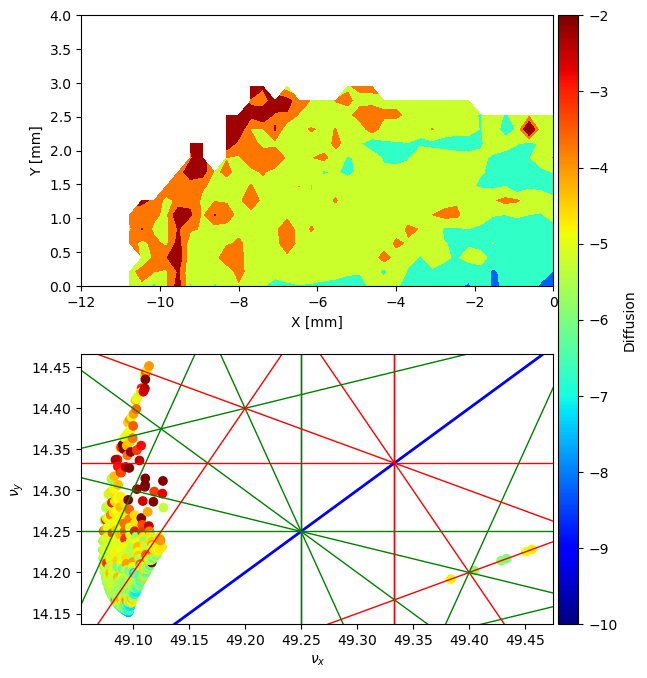

In [12]:
global phase, gap
for phase in PHASES:
    for gap in GAPS:
        print(phase, gap)
        model1 = analysis()
        # analysis_dynapt_map(model1)